# Asymmetry `n_m_bg_start=2`

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
import lightkurve as lk
from matplotlib import pyplot as plt
import numpy as np
from astropy.table import Table
from analysis_tools_cython import *
import scipy.integrate as integrate
import numpy as np
from scipy.signal import savgol_filter

plt.rcParams["figure.figsize"] = (10, 6)

## Functions

In [3]:
def skewed_gaussian_curve_fit(x, y):
    # Initial parameters guess
    ## i = index of min time
    ## x = time
    ## y = flux

    i = np.argmin(y)

    ### params initialisation for skewness, time, mean and sigma
    params_init = [1, x[i], 0.1, 0.0001]  # i find these good to initialise with

    # params_bounds = [[0,x[0],0,-np.inf], [np.inf,x[-1],np.inf,np.inf]]
    params, cov = curve_fit(
        updated_skewed_gauss, x, y, p0=params_init, maxfev=1000000
    )  # ,bounds=params_bounds)
    return params, cov


def skewed_gaussian(x, a, mean, sigma, m):
    """
    m: amplitude
    x: time
    a: skewness
    mean: time
    sigma: sigma/standard deviation

    """
    return -m * skewnorm.pdf(x, a, loc=mean, scale=sigma)


def lookup_tic(tic):
    return lookup[lookup.TIC_ID == tic]


def search_method(data):
    try:
        data = data["time", "corrected flux", "quality", "flux error"]
    except:
        data = data["TIME", "PDCSAP_FLUX", "QUALITY", "PDCSAP_FLUX_ERR"]

    flat_flux, trend_flux = smoothing(data, method="median")
    a = Table()
    a["time"] = data[data.colnames[0]]
    a["flux"] = flat_flux - np.ones(len(flat_flux))
    a["quality"] = data[data.colnames[2]]
    a["flux_error"] = data[data.colnames[3]]
    # table[table.colnames[1]] = flat_flux - np.ones(len(flat_flux)) # resets normalisation to zero instead of one.
    t, flux, quality, real, flux_error = clean_data(a)
    flux *= real
    timestep = calculate_timestep(data)
    factor = (1 / 48) / timestep

    T1 = test_statistic_array(flux, 60 * factor)

    m, n = np.unravel_index(
        T1.argmin(), T1.shape
    )  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
    minT = T1[m, n]
    # Ts = nonzero(T1[m,n]).std()
    minT_time = t[n]
    minT_duration = m * timestep
    Tm_start = n - math.floor((m - 1) / 2)
    Tm_end = Tm_start + m
    Tm_depth = flux[Tm_start:Tm_end].mean()
    Ts = nonzero(T1[m]).std()  # only the box width selected. Not RMS of all T-statistic

    asym, width1, width2, depth, info = calc_shape(
        m, n, t, flux, quality, flux_error, n_m_bg_start=2
    )
    return info[0], info[1]


def plot(data):
    time, flux = search_method(data)
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    try:
        ax[0].plot(data["time"], data["corrected flux"])
    except:
        ax[0].plot(data["TIME"], data["PDCSAP_FLUX"])
    ax[1].plot(time, flux)
    ax[1].plot(time, fit, label="gaussian")
    ax[1].plot(time, fit2, color="black", label="skewed gaussian")
    ax[1].legend()
    plt.show()

In [4]:
lookup = pd.read_csv("/storage/astro2/phrdhx/tesslcs/sector1lookup.csv")

## Example 1

In [5]:
data, lc_info = import_lightcurve(
    "betapic/test/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits"
)

In [6]:
time, flux = search_method(data)

In [7]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit(time, flux)

In [8]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 2.762+/-0.119


In [9]:
fit = -gauss(time, *params)
fit2 = updated_skewed_gauss(time, *params1)

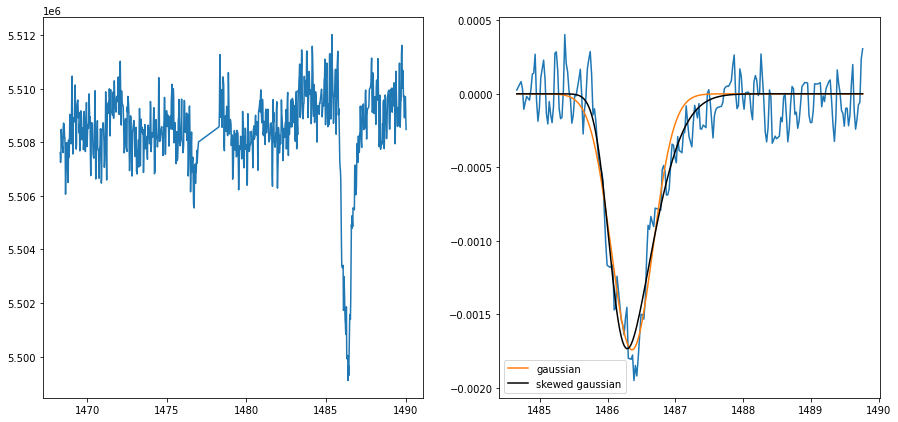

In [10]:
plot(data)

In [11]:
len(flux)

246

### 1a. Flip this lightcurve to see if the skew works in reverse as well

In [12]:
data = data.to_pandas()

In [13]:
data.head()

,TIME,PDCSAP_FLUX,QUALITY,PDCSAP_FLUX_ERR
0,1468.304154,5507612.0,0,64.862846
1,1468.324987,5507246.5,0,64.860832
2,1468.345820,5507478.5,0,64.863037
3,1468.366654,5508482.0,0,64.867645
4,1468.408320,5507866.5,0,64.860580


In [14]:
data.PDCSAP_FLUX = data.PDCSAP_FLUX.values[::-1]

In [15]:
data = Table.from_pandas(data)

In [16]:
time, flux = search_method(data)

In [17]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit(time, flux)

In [18]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is -3.078+/-0.195


In [19]:
fit = -gauss(time, *params)
fit2 = updated_skewed_gauss(time, *params1)

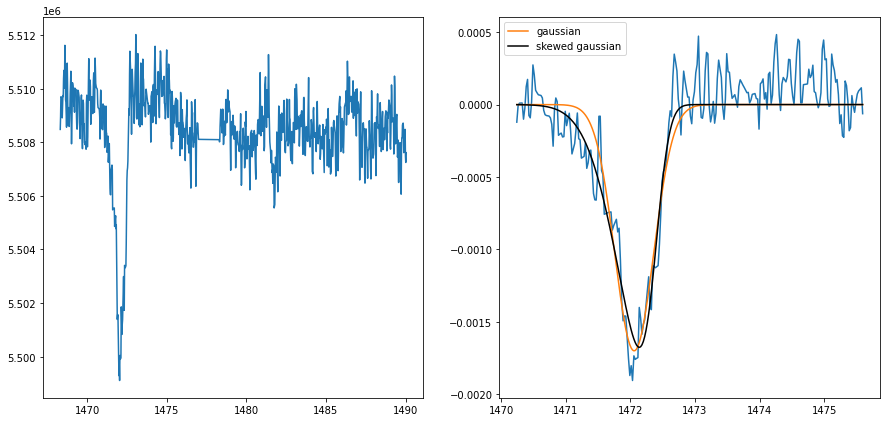

In [20]:
plot(data)

Appears to fit the data quite well.

### Goodness of fit of model

In [21]:
chisquare = np.sum(((flux - fit2) ** 2) / fit2**2)

In [22]:
chisquare

5.387157725753049e+162

In [23]:
from scipy.stats import chisquare

In [24]:
chisquare(flux, fit2)

Power_divergenceResult(statistic=-1.9059473746421574e+77, pvalue=1.0)

---

## Example 2 (CTOI)

In [12]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_50380257.pkl",
    sector=1,
)

In [13]:
time, flux = search_method(data)

In [14]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit(time, flux)

In [15]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 1.374+/-0.355


In [16]:
fit = -gauss(time, *params)
fit2 = updated_skewed_gauss(time, *params1)

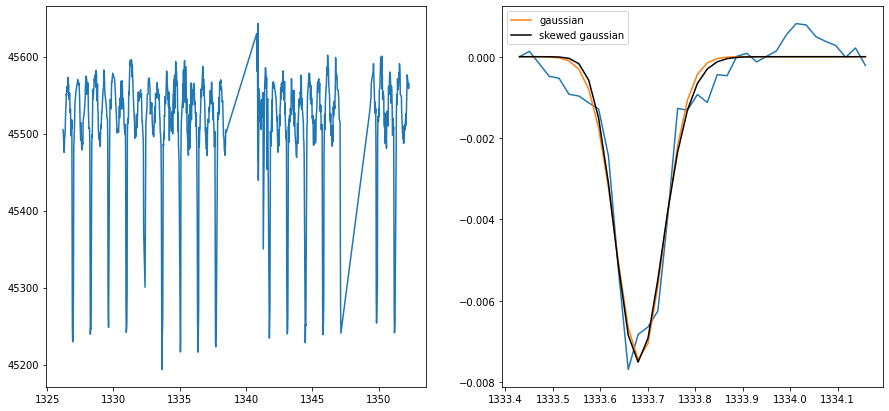

In [17]:
plot(data)

In [18]:
len(flux)

36

---
## Example 3 (CTOI)

In [19]:
lookup_tic(55659311)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
12943,tesslcs_sector_1_104/2_min_cadence_targets/tes...,74.117326,-64.48753,55659311,1,4,1,9.7909


In [20]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_55659311.pkl",
    sector=1,
)

In [21]:
time, flux = search_method(data)

In [22]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit(time, flux)

In [23]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 0.132+/-5.965


In [24]:
fit = -gauss(time, *params)
fit2 = updated_skewed_gauss(time, *params1)

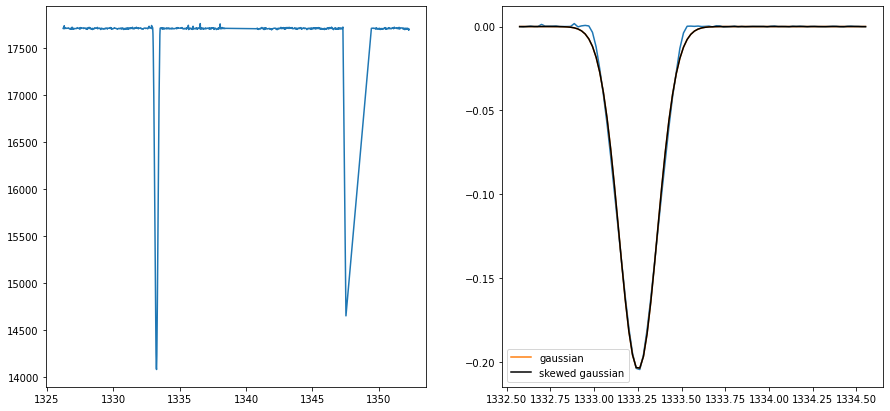

In [25]:
plot(data)

In [26]:
len(flux)

96

---
## Example 4 (EA2)

In [27]:
lookup_tic(60646247)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
53662,tesslcs_sector_1_104/tesslcs_tmag_11_12/tesslc...,334.360488,-33.134487,60646247,1,1,2,11.851


In [28]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/tesslcs_tmag_11_12/tesslc_60646247.pkl",
    sector=1,
)

In [29]:
time, flux = search_method(data)

In [30]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit(time, flux)

In [31]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 0.036+/-1602.65


In [32]:
fit = -gauss(time, *params)
fit2 = updated_skewed_gauss(time, *params1)

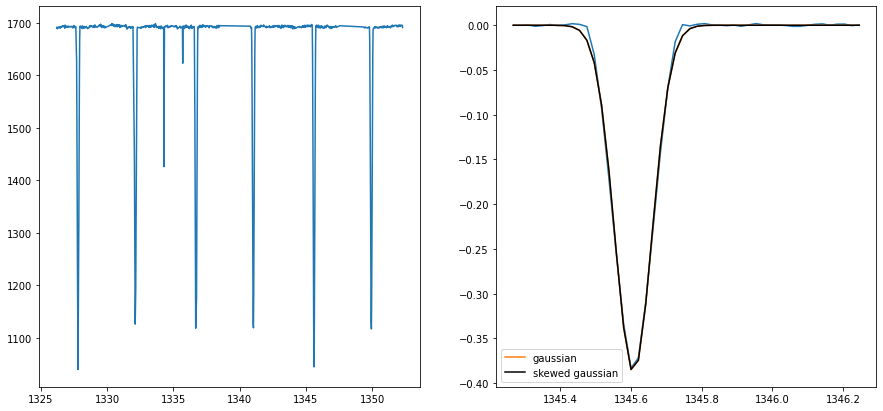

In [33]:
plot(data)

In [34]:
len(flux)

48

---
## Example 5 (WASP 100)

In [35]:
lookup_tic(38846515)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
12850,tesslcs_sector_1_104/2_min_cadence_targets/tes...,68.959709,-64.027037,38846515,1,4,1,10.3157


In [36]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_38846515.pkl",
    sector=1,
)

In [37]:
time, flux = search_method(data)

In [38]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit(time, flux)

In [39]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 14752.116+/-7761685415331833.0


In [40]:
params

array([8.47532267e-03, 1.32674677e+03, 4.26391297e-02])

In [41]:
fit = -gauss(time, *params)
fit2 = updated_skewed_gauss(time, *params1)

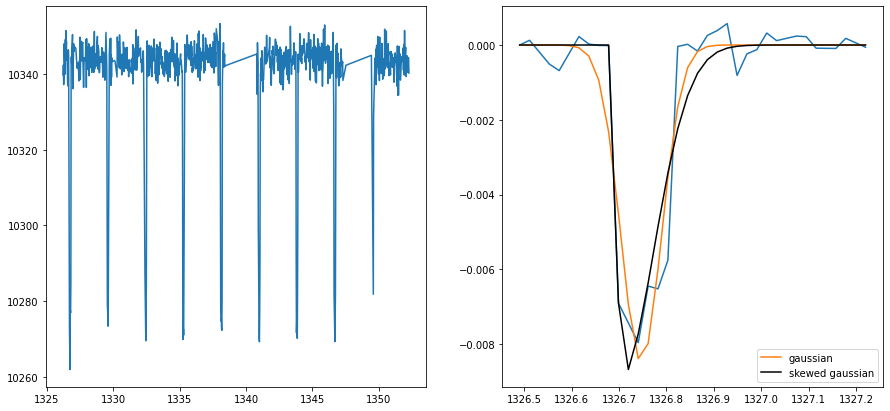

In [42]:
plot(data)

In [43]:
len(flux)

36

---
## Example 6

In [44]:
lookup_tic(61178236)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
43296,tesslcs_sector_1_104/tesslcs_tmag_10_11/tesslc...,334.803809,-31.688934,61178236,1,1,2,10.8952


In [45]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/tesslcs_tmag_10_11/tesslc_61178236.pkl",
    sector=1,
)

In [46]:
time, flux = search_method(data)

In [47]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit(time, flux)

In [48]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 1177.483+/-8535508742762.606


In [49]:
params

array([1.27991527e-01, 1.35117622e+03, 3.22892900e-02])

In [50]:
fit = -gauss(time, *params)
fit2 = updated_skewed_gauss(time, *params1)

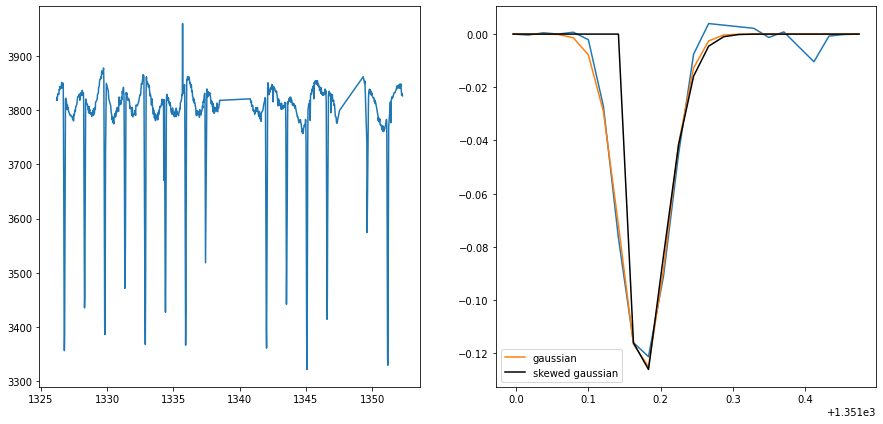

In [51]:
plot(data)

In [52]:
len(flux)

24

### Test interpolate

In [53]:
arange = np.linspace(time.min(), time.max(), 5000)
interp = np.interp(arange, time, flux)

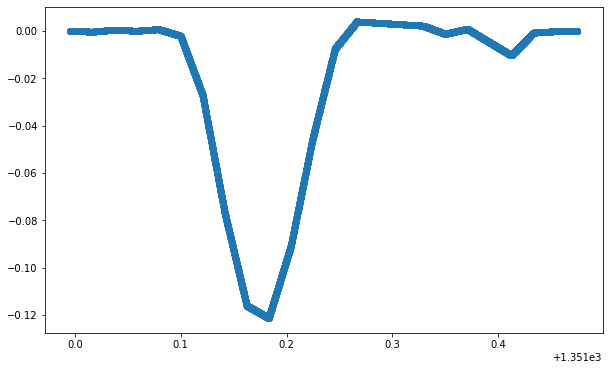

In [54]:
plt.scatter(arange, interp)